In [40]:
import sys
import yaml
sys.path.append('../')
import os
import torch
from misc import yaml_util as yu
sys.path.append('../dataset')
sys.path.append('../module')
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca


In [41]:
datname = 'OneDsignal_c8mimic'
#datname = 'OneDCyclic'
modelname = 'mask2Stacklayer'
#modelname = 'mlp1layer_nonDim'
#modelname = 'mask1layer'

trainname = 'baseline'
with open(f'''../cfg_data/{datname}.yaml''', 'rb') as f:
    cfg_data = yaml.safe_load(f)

cfg_data['args']['shift_label'] = True
mydata = yu.load_component(cfg_data) 

myloader = DataLoader(mydata, batch_size=20,
                        shuffle=True, 
                        num_workers=1,
                        )


seq, shift =  mydata[0]
seq = seq[None, :]
print(seq.shape)

expname = f'''{datname}_{modelname}_{trainname}'''

exppath = os.path.join("../dnftresult", expname)
if not os.path.exists(exppath):
    raise NotImplementedError
mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)
mymodel = mymodel.to(0)
mymodel

./dataset/oneDsignal_data.py
[0, 8, 16, 32, 56]
0
torch.Size([1, 3, 128])


DFNFT(
  (owndecoders): ModuleList(
    (0): MLPDecoder(
      (activation_fxn): Tanh()
      (net): Sequential(
        (0): MaskFlatLinear()
        (1): Linear(in_features=130, out_features=128, bias=True)
      )
    )
    (1): MLPDecoder(
      (activation_fxn): Tanh()
      (net): Sequential(
        (0): MaskFlatLinear()
      )
    )
  )
  (nftlayers): ModuleList(
    (0): NFT(
      (encoder): MLPEncoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): Linear(in_features=128, out_features=130, bias=True)
          (1): MaskFlatLinear()
        )
      )
      (decoder): MLPDecoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): MaskFlatLinear()
          (1): Linear(in_features=130, out_features=128, bias=True)
        )
      )
    )
    (1): NFT(
      (encoder): MLPEncoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): MaskFlatLinear()
        )
      )
      (decoder): MLPDecoder(
        (

In [42]:

Ms = []
shifts = [] 
for k in range(100):
    evalseq, shift = next(iter(myloader))
    evalseq = evalseq[:, :2].to(mymodel.nftlayers[0].encoder.device)
    predicted = mymodel(evalseq, n_rolls=1)
    shifts.append(shift)
    Ms.append(mymodel.nftlayers[-1].dynamics.M) 
    
shifts = torch.concatenate(shifts)
Ms = torch.concatenate(Ms)

In [43]:
def replace_lowhalf(sqM):
    n, b, b = sqM.shape
    blocksize = b //2 
    zeroblock = torch.zeros(blocksize, blocksize)
    eyeblock = torch.eye(blocksize)
    maskup = torch.block_diag(eyeblock,  zeroblock).to(dtype=sqM.dtype)
    masklow = torch.block_diag(zeroblock,  eyeblock).to(dtype=sqM.dtype)
    
    sqM = sqM @ maskup + masklow * 0
    return sqM 

def replace_uphalf(sqM):
    n, b, b = sqM.shape
    blocksize = b //2 
    zeroblock = torch.zeros(blocksize, blocksize)
    eyeblock = torch.eye(blocksize)
    maskup = torch.block_diag(eyeblock,  zeroblock).to(dtype=sqM.dtype)
    masklow = torch.block_diag(zeroblock,  eyeblock).to(dtype=sqM.dtype)
    
    sqM = sqM @ masklow + maskup * 0 
    return sqM 

In [44]:
Mup = replace_lowhalf(Ms.to('cpu'))
Mbot = replace_uphalf(Ms.to('cpu'))

In [45]:
targfreqUp, prodsUp = ca.inner_prod(Mup.to(shifts.device), shifts, maxfreq=64, bins=65)
targfreqBot, prodsBot = ca.inner_prod(Mbot.to(shifts.device), shifts, maxfreq=64, bins=65)

100%|██████████| 65/65 [00:18<00:00,  3.53it/s]


(array([ 0, 32]),)


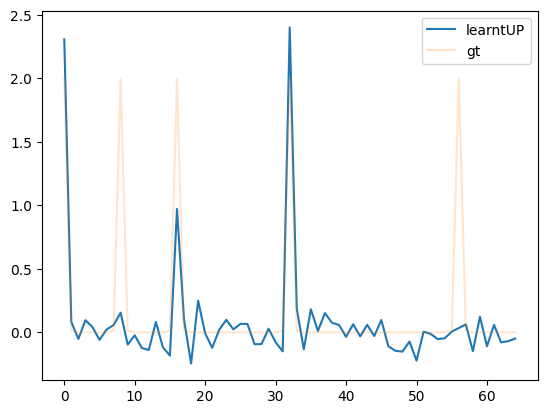

In [46]:
import numpy as np
plt.figure()
plt.plot(targfreqUp, prodsUp, label='learntUP')
deltas = ca.deltafxn(targfreqUp, mydata.freqsel)*2
plt.plot(targfreqUp, deltas, label='gt',alpha=0.2)
plt.legend()
print(np.where(prodsUp > 1) ) 

(array([ 8, 16, 56]),)


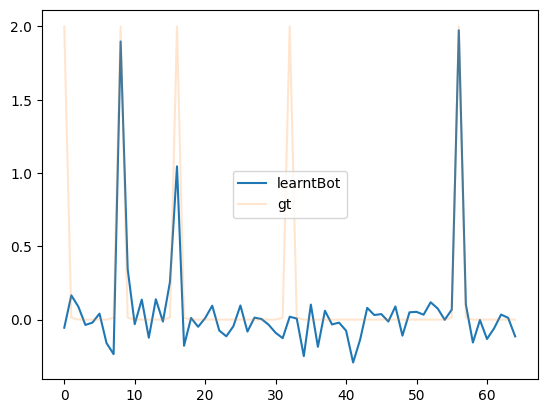

In [47]:
plt.figure()
plt.plot(targfreqBot, prodsBot, label='learntBot', alpha=1.0)
#plt.plot(targfreqBot, prodsUp, label='learntUp', alpha=0.6)

deltas = ca.deltafxn(targfreqBot, mydata.freqsel)*2
plt.plot(targfreqBot, deltas, label='gt', alpha=0.2)
print(np.where(prodsBot > 1) ) 
plt.legend()

In [31]:
mymodel.nftlayers[0].encoder.maskmat

Parameter containing:
tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]], device='cuda:0',
       dtype=torch.float64)

In [32]:
mymodel.nftlayers[0].encoder

MLPEncoder(
  (activation_fxn): Tanh()
  (net): Sequential(
    (0): Linear(in_features=128, out_features=130, bias=True)
    (1): MaskFlatLinear()
  )
)